In [1]:
# %matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import requests
import re

import requests
from bs4 import BeautifulSoup, Comment
import time

import pickle

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

## SETUP:

Get list of all CBB conferences

In [20]:
url_master = "https://www.sports-reference.com/cbb/conferences/"
r_master = requests.get(url_master).content
soup_master = BeautifulSoup(r_master,'lxml')

cols = ['Conference', 'From', 'To', 'W', 'L', 'W-L' ,'SRS', 'SOS', 'AP', 'NCAA', 'FF', 'NC']
master_df = pd.DataFrame(columns = cols + ['url'])

tbls = soup_master.findAll('table', {'class': 'sortable stats_table'})
for t in tbls:
    for tr in t.find_all('tr')[1:]:
        tds = tr.find_all('td')
        
        new_df = pd.DataFrame([[elem.text for elem in tds]], columns=cols)
        new_df['url'] = tds[0].find('a').get('href')
        master_df = master_df.append(new_df)
        
master_df.to_csv('conference_list.csv', index=False, encoding='utf-8')

For all conferences active in NCAAT era, get list of conference games and list of conference tournament games (to remove from full list)

In [21]:
master_df = pd.read_csv('conference_list.csv')

In [22]:
# Start analysis at 1939 (previously many teams played as independents)

master_df = master_df[master_df['To']>=1939]
master_df = master_df[master_df['Conference']!="Independent"]
master_df.tail()

,Conference,From,To,W,L,W-L,SRS,SOS,AP,NCAA,FF,NC,url
49,Northern California Conference,1938,1939,106,90,0.541,NaN,NaN,0,0,0,0,/cbb/conferences/northern-ca/
50,Skyline Conference,1911,1962,4228,3627,0.538,-1.56,-0.56,10,23,3,1,/cbb/conferences/skyline/
51,Southwest Conference,1915,1996,7892,6982,0.531,0.46,0.92,21,78,12,0,/cbb/conferences/swc/
52,Western New York Little Three Conference,1947,1958,565,343,0.622,4.21,2.76,3,3,0,0,/cbb/conferences/wny3/
53,Yankee Conference,1938,1976,1918,1706,0.529,-11.88,-8.73,0,14,0,0,/cbb/conferences/yankee/


In [23]:
url_base = 'https://www.sports-reference.com/'
url_cap = '-schedule.html'
url_tourney_cap = '.html'
years = range(2018, 2019)

In [24]:
def date_parser(s):
    return s[5:-6].strip()

def date_parser_tourney(s):
    return s[5:].strip()

In [29]:
%%time

# MASTER ITERATION:

game_cols = ['Date', 'Away', 'Away_Pts', 'Home', 'Home_Pts', 'OT', 'Notes']
games_df = pd.DataFrame(columns=game_cols + ['Conference','Year'])
tourney_cols = ['Date','Away','Away_Pts','At','Home','Home_Pts','OT','Box']
        
for index, row in master_df.iterrows():
    conf_df = pd.DataFrame(columns=game_cols + ['Conference','Year'])
    
    for y in years:
        # if out of range, skip
        if (y < row[1]) or (y > row[2]):
            continue
        
        time.sleep(5)
        
        # **** GET LIST OF CONFERENCE GAMES ****
        
        new_df = pd.DataFrame(columns=game_cols)
        
        u = url_base + row[-1] + str(y) + url_cap
        u_tourney = url_base + row[-1] + str(y) + url_tourney_cap
        
        # get main table of games:
        r = requests.get(u).content
        soup = BeautifulSoup(r,'lxml')
        
        if 'Page Not Found' in soup.find('title').text:
            continue
        
        games_tbl = soup.find('table', {'id': 'schedule'})
        
        # iterate through every game on table:
        for tr in games_tbl.findAll('tr'):
            tds = tr.findAll(['th', 'td']) # first column = th tags
            
            temp_df = pd.DataFrame([[elem.text for elem in tds]], columns=game_cols)
            new_df = new_df.append(temp_df)
            
        # remove duplicate header rows and top header row
        new_df = new_df.drop_duplicates()[1:]
        new_df['Conference'] = row[0]
        new_df['Year'] = y
        
        
        # **** GET LIST OF TOURNAMENT GAMES ****
        r_tourney = requests.get(u_tourney).content
        soup_tourney = BeautifulSoup(r_tourney, 'lxml')
        
        tourney_df = pd.DataFrame(columns=tourney_cols)
        comments = soup_tourney.findAll(text=lambda text:isinstance(text, Comment))

        for c in comments:
            comment_soup = BeautifulSoup(comments[15], 'lxml')
            tourney_tbl = comment_soup.find('table', {'id': 'conference-tournament'})
            if tourney_tbl is not None:
                break
    
        # iterate through every game on table:
        try: 
            trs = tourney_tbl.findAll('tr')
            for tr in trs:
                tds = tr.findAll(['th', 'td']) # first column = th tags
                tourney_temp = pd.DataFrame([[elem.text for elem in tds]], columns=tourney_cols)
                tourney_df = tourney_df.append(tourney_temp)
        except AttributeError: 
            pass
            
        
        # **** MERGE AND DROP CONFERENCE TOURNAMENT GAMES ****
        
        new_df['Date_clean'] = new_df['Date'].apply(lambda x: date_parser(str(x)))
        
        tourney_df['Date_clean'] = tourney_df['Date'].apply(lambda x: date_parser_tourney(str(x)))
        tourney_df['Tourney']='Y'
        tourney_days = tourney_df[['Date_clean','Tourney']].drop_duplicates()
        
        new_df = new_df.merge(tourney_days, on='Date_clean', how='left')
        new_df = new_df[new_df['Tourney']!="Y"].drop(['Date_clean','Tourney'], axis=1)
        
        # ADD TO MASTER:
        
        conf_df = conf_df.append(new_df)
        
        
    games_df = games_df.append(conf_df)
    #games_df.to_csv('conference_games_working.csv', index=False)

games_df.to_csv('conference_games_2018.csv', index=False)

Wall time: 3min 22s


In [ ]:
for i in ['Away_Pts','Home_Pts','Year']:
     games_df[i] = pd.to_numeric(games_df[i], errors='coerce')

In [44]:
out_df = pd.concat([pd.read_csv('conference_games_2017.csv'), games_df])
out_df.to_csv('conference_games.csv')

C:\Users\Whitaker Kevin\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## ANALYSIS

National trend for home-court advantage in conference games over time

##### 1. What is the trend in HCA over time?

In [2]:
# feed in cleaned data
master_df = pd.read_csv('conference_games.csv')
master_df.describe(include='all')

,Unnamed: 0,Date,Away,Away_Pts,Home,Home_Pts,OT,Notes,Conference,Year
count,108937.000000,108937,108937,108937.000000,108937,108937.000000,4145,316,108937,108937.000000
unique,NaN,5622,372,NaN,372,NaN,5,11,48,NaN
top,NaN,"Sat, Feb 4, 2017",Georgia,NaN,Alabama,NaN,OT,Quarterfinal,Southeastern Conference,NaN
freq,NaN,153,603,NaN,602,NaN,3426,110,6600,NaN
mean,51159.579124,NaN,NaN,68.920110,NaN,72.726493,NaN,NaN,NaN,1994.674757
std,31358.454829,NaN,NaN,12.489566,NaN,13.139550,NaN,NaN,NaN,17.784193
min,0.000000,NaN,NaN,10.000000,NaN,12.000000,NaN,NaN,NaN,1950.000000
25%,23872.000000,NaN,NaN,60.000000,NaN,64.000000,NaN,NaN,NaN,1984.000000
50%,51106.000000,NaN,NaN,68.000000,NaN,72.000000,NaN,NaN,NaN,1998.000000
75%,78340.000000,NaN,NaN,77.000000,NaN,81.000000,NaN,NaN,NaN,2009.000000


In [3]:
master_df['Home_Win_Pct'] = np.where( (master_df['Home_Pts'] > master_df['Away_Pts']), 100, 0)
master_df['Home_Margin'] = master_df['Home_Pts'] - master_df['Away_Pts']
master_sum = master_df.groupby(['Year'])['Home_Win_Pct','Home_Margin'].mean()
    # average winning percentage and scoring margin for home teams

In [4]:
master_sum[60:].round(1)

,Home_Win_Pct,Home_Margin
Year,,
2010,61.1,3.4
2011,60.9,3.3
2012,60.6,3.6
2013,61.2,3.5
2014,60.3,3.1
2015,59.8,3.2
2016,60.5,3.2
2017,59.0,2.8
2018,61.8,3.6


In [5]:
def draw_graph(df, colors, label_bool): # dataframe of graphs to be drawn; list of colors
    
    fig, ax = plt.subplots(figsize=(9,5))
    plt.tick_params(axis='both', which='major', labelsize=14)

    #ax.set_xlabel('Year', fontsize=14)
    ax.set_ylabel(y_label, fontsize=14)
    
    #ax.set_xlim(-0.5,4.5)
    #ax.set_ylim(75,125)
    
    #x_labels = ['< 20', '20-25', '25-30', '30-35', '35 +', '']
    #plt.xticks(range(0, 5), x_labels, fontsize=14)
    
    ix = 0
    for i in df.columns:
        ax.plot(df[i], '-', color=colors[ix])
        if label_bool:
            ax.text(2018.5, df.loc[2018, i], i, ha='left', va='center', fontsize=14, color=colors[ix])
        ix = ix+1
    
    if label_bool==False:
        # custom labels
        ax.text(2018.5, df.loc[2018, df.columns[0]], df.columns[0], ha='left', va='center', fontsize=14, color=colors[0])
        ax.text(2018.5, df.loc[2018, df.columns[1]]+0.1, df.columns[1], ha='left', va='center', fontsize=14, color=colors[1])
        
    ax.set_title(title, fontsize=16)
    
    y_min = ax.get_ylim()[0]
    y_max = ax.get_ylim()[1]
    y_range = (y_max - y_min)
    ax.text(2025, y_min - 0.1*y_range, "Note: Raw data via Sports-Reference.com; includes conference play only", ha='right', va='center', fontsize=10, color="#aaaaaa")
    #ax.text(2025, y_min - 0.1*y_range, "Note: Normalized to overall 2018 scoring environment. Raw data via Sports-Reference.com; analysis by NYC Buckets", ha='right', va='center', fontsize=10, color="#aaaaaa")
    
    sns.despine()
    #return data
    

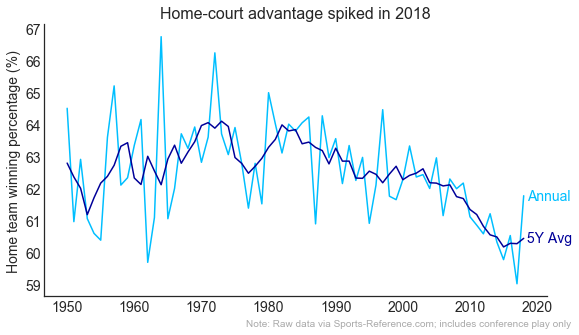

In [6]:
### WINNING PERCENTAGE:

# general parameters:
title = "Home-court advantage spiked in 2018"
y_label = "Home team winning percentage (%)"
f_name = "NCAA_home_court_advantage_win_pct"
colors = ['#00BFFF', '#000099']

output_pct = master_sum[['Home_Win_Pct']].rename(columns={'Home_Win_Pct': 'Annual'})
output_pct['5Y Avg'] = output_pct['Annual'].rolling(5, center=True, min_periods=1).mean()
#output_pct.tail()

sns.set_style('white')
draw_graph(output_pct, colors, True)
#plt.savefig("imgs/"+f_name+".jpg", bbox_inches="tight")
plt.show()
plt.close()

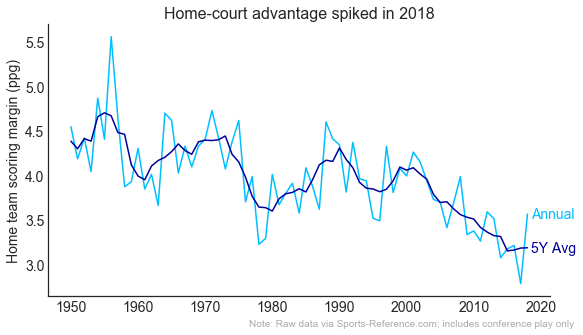

In [8]:
### SCORING MARGIN:

# general parameters:
title = "Home-court advantage spiked in 2018"
y_label = "Home team scoring margin (ppg)"
f_name = "NCAA_home_court_advantage_margin_raw"
colors = ['#00BFFF', '#000099']

output_mgn = master_sum[['Home_Margin']].rename(columns={'Home_Margin': 'Annual'})
output_mgn['5Y Avg'] = output_mgn['Annual'].rolling(5, center=True, min_periods=1).mean()

sns.set_style('white')
#draw_graph(output_mgn, colors, False)
draw_graph(output_mgn, colors, True)
plt.savefig("imgs/"+f_name+".jpg", bbox_inches="tight")
plt.show()
plt.close()

## DRIVERS OF HOME-COURT ADVANTAGE

##### 2A. Does HCA depend on distance traveled?

##### Setup distance:

In [24]:
from geopy.geocoders import Nominatim

school_df = pd.read_csv('school_list.csv', index_col='Rk')
school_df.head()

,School,"City, State"
Rk,,
1,Abilene Christian Wildcats,"Abilene, Texas"
2,Air Force Falcons,"USAF Academy, Colorado"
3,Akron Zips,"Akron, Ohio"
4,Alabama A&M Bulldogs,"Normal, Alabama"
5,Alabama Crimson Tide,"Tuscaloosa, Alabama"


In [26]:
%%time
geolocator = Nominatim()

for index, row in school_df[290:].iterrows(): # FIX INDEX
    geolocator = Nominatim()
    location = geolocator.geocode(row[1], timeout=10)
    
    try: 
        school_df.loc[index, 'Latitude'] = location.latitude
    except AttributeError:
        continue

    school_df.loc[index, 'Longitude'] = location.longitude
    time.sleep(1)
    
    #if index%10==0:
    #    school_df.to_csv('school_locations.csv', index=False)

#school_df.to_csv('school_locations.csv', index=False)

Wall time: 5min 27s


Sanitize school name:

In [33]:
r = requests.get('https://www.sports-reference.com/cbb/schools/').content
soup = BeautifulSoup(r,'lxml')

link_cols = ['href', 'text']
new_df = pd.DataFrame(columns=link_cols)

games_tbl = soup.find('table', {'id': 'schools'})

for a in games_tbl.findAll('a'):
    txt = a.text
    h = a.get('href')
    
    temp_df = pd.DataFrame([[h, txt]], columns=link_cols)
    new_df = new_df.append(temp_df)

            
# remove duplicate header rows and top header row
new_df = new_df.drop_duplicates()
new_df.head()

,href,text
0,/cbb/schools/abilene-christian/,Abilene Christian Wildcats
0,/cbb/schools/air-force/,Air Force Falcons
0,/cbb/schools/akron/,Akron Zips
0,/cbb/schools/alabama-am/,Alabama A&M Bulldogs
0,/cbb/schools/alabama/,Alabama Crimson Tide


In [35]:
# Temp file to help with name cleaning:

new_df['School'] = new_df['text']
new_df['Title'] = new_df['href'].apply(lambda x: str(x).split("/")[-2].replace("-", " "))
#new_df.head()
#new_df[['School','Title']].to_csv('name_cleaning.csv', index=False)

##### Pick up from cleaned files:

In [9]:
school_df = pd.read_csv('school_locations.csv')
helper_df = pd.read_csv('names_clean.csv')
helper_df.head()
school_df = school_df.merge(helper_df[['School','Title_Clean']], how='left', on='School').drop('School', axis=1).rename(columns={'Title_Clean':'School'})
school_df.head()

# feed in game data
master_df = pd.read_csv('conference_games.csv')
#master_df = games_df
master_df['Home_Win'] = np.where( (master_df['Home_Pts'] > master_df['Away_Pts']), 100, 0)
master_df['Home_Margin'] = master_df['Home_Pts'] - master_df['Away_Pts']
#master_df.describe()

In [10]:
# Prepare to calculate distance:
dist_df = master_df.merge(school_df[['School','Latitude','Longitude']], how='left', left_on='Away', right_on='School', suffixes=('','_Away'))\
                    .merge(school_df[['School','Latitude','Longitude']], how='left', left_on='Home', right_on='School', suffixes=('','_Home'))

#dist_df.head()

In [11]:
import math

def distance(origin, destination):
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 3959 # miles

    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c

    return d

In [12]:
%%time
dist_df = dist_df[['Year','Home_Win','Home_Margin','Latitude','Longitude','Latitude_Home','Longitude_Home']]

for index, row in dist_df.iterrows():
    loc1 = (row[3], row[4])
    loc2 = (row[5], row[6])
    dist_df.loc[index, 'Distance'] = distance(loc1, loc2)
#dist_df.head()

Wall time: 5min 20s


In [13]:
bins = [-1, 200, 500, 9999]
lbls =['<200 mi','200-500','>500 mi']

dist_df['D'] = pd.cut(dist_df['Distance'], bins, labels=lbls)
dist_df.head()
#dist_df.to_csv('raw_distance_data.csv', index=False)

,Year,Home_Win,Home_Margin,Latitude,Longitude,Latitude_Home,Longitude_Home,Distance,D
0,2014,0,-25,38.254238,-85.759407,28.542123,-81.379047,716.828787,>500 mi
1,2014,100,4,41.808431,-72.249523,29.758938,-95.367697,1532.554305,>500 mi
2,2014,0,-15,35.149022,-90.051629,27.947759,-82.458444,668.486033,>500 mi
3,2014,100,8,32.776272,-96.796856,39.101454,-84.512460,813.300953,>500 mi
4,2014,100,5,39.952399,-75.163590,40.486217,-74.451817,52.638549,<200 mi


In [14]:
metric = "Home_Margin" # toggle with Home_Win to analyze different metrics

In [15]:
mid_df = dist_df.groupby(['Year','D'])[metric].mean().reset_index()

# If using scoring margin, merge in normalized metric:
#if metric == "Home_Margin":
#    mid_df = mid_df.merge(score_index[['Index']], left_on='Year', right_index=True)
#    mid_df['Home_Margin'] = mid_df['Home_Margin'] / mid_df['Index']


mid_df = mid_df.pivot('Year','D',metric)

# set rolling average
roll = 1
graph_df = mid_df.rolling(roll, center=True, min_periods=1).mean()
graph_df.head()

D,<200 mi,200-500,>500 mi
Year,,,
1950,3.318725,6.121053,4.875000
1951,3.358209,4.368627,7.285714
1952,3.776596,4.034043,9.634615
1953,3.937063,4.051064,4.659091
1954,4.037037,5.224215,8.450000


In [16]:
def draw_graph(df, colors, label_bool): # dataframe of graphs to be drawn; list of colors
    
    fig, ax = plt.subplots(figsize=(9,5))
    plt.tick_params(axis='both', which='major', labelsize=14)

    #ax.set_xlabel('Year', fontsize=14)
    ax.set_ylabel(y_label, fontsize=14)
    
    #ax.set_xlim(-0.5,4.5)
    #ax.set_ylim(75,125)
    
    #x_labels = ['< 20', '20-25', '25-30', '30-35', '35 +', '']
    #plt.xticks(range(0, 5), x_labels, fontsize=14)
    
    ix = 0
    for i in df.columns:
        ax.plot(df[i], '-', color=colors[ix])
        if label_bool:
            ax.text(2018.5, df.loc[2018, i], i, ha='left', va='center', fontsize=14, color=colors[ix])
        ix = ix+1
    
    if label_bool==False:
        # custom labels
        ax.text(2018.5, df.loc[2018, df.columns[0]]-0.2, df.columns[0], ha='left', va='center', fontsize=14, color=colors[0])
        ax.text(2018.5, df.loc[2018, df.columns[1]], df.columns[1], ha='left', va='center', fontsize=14, color=colors[1])
        ax.text(2018.5, df.loc[2018, df.columns[2]], df.columns[2], ha='left', va='center', fontsize=14, color=colors[2])
        
    ax.set_title(title, fontsize=16)
    
    y_min = ax.get_ylim()[0]
    y_max = ax.get_ylim()[1]
    y_range = (y_max - y_min)
    ax.text(2025, y_min - 0.1*y_range, "Note: Raw data via Sports-Reference.com; includes conference games only", ha='right', va='center', fontsize=10, color="#aaaaaa")
    
    sns.despine()
    #return data
    

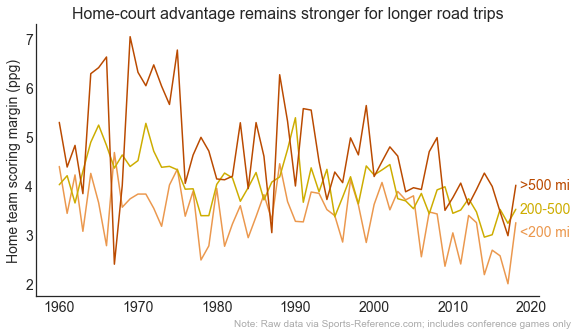

In [17]:
# general parameters:
title = "Home-court advantage remains stronger for longer road trips"
y_label = "Home team scoring margin (ppg)"
f_name = "NCAA_home_court_advantage_distance"
colors = ['#eb984e', '#CDAD00', '#ba4a00']

sns.set_style('white')
draw_graph(graph_df[10:], colors, False)
plt.savefig("imgs/"+f_name+".jpg", bbox_inches="tight")
plt.show()
plt.close()

Home-court advantage is stronger for longer road trips than shorter ones

However, the difference has been roughly stable since the 90s, suggesting better travel methods do not explain the recent decline (nor 2018 increase)

##### 2B. Is HCA stronger for power conferences or mid-majors?

In [97]:
input_df = pd.read_csv('conference_list.csv')

conf_df = pd.read_csv('conference_games.csv')[['Conference','Year']].drop_duplicates().reset_index()
conf_df = conf_df[['Conference','Year']].merge(input_df[['Conference','Type']], how='left', on='Conference')
conf_df.head()

,Conference,Year,Type
0,American Athletic Conference,2014,NaN
1,American Athletic Conference,2015,NaN
2,American Athletic Conference,2016,NaN
3,American Athletic Conference,2017,NaN
4,Atlantic Coast Conference,1980,Power


##### Define conference strength:

In [100]:
%%time

### Iterate through conference lists by year to find number of NCAA tournament bids
url_base = 'https://www.sports-reference.com/'
cols = ['Rk', 'Season', 'Schls', 'W', 'L', 'W-L%', 'SRS', 'SOS', 'AP', 'NCAA', 'Regular Season Champ', 'Tournament Champ', 'POY']
conf_master = pd.DataFrame(columns=cols)
conf_master['Conference'] = ""

for index, row in input_df[['Conference','url','Type']].iterrows():
    
    time.sleep(5)
        
    u = url_base + row[1]
    
    # get main table of games:
    r = requests.get(u).content
    soup = BeautifulSoup(r,'lxml')
        
    if 'Page Not Found' in soup.find('title').text:
        continue
        
    conf_tbl = soup.find('table', {'class': 'sortable stats_table'})
    new_df = pd.DataFrame(columns=cols)
    
    # iterate through every game on table:
    for tr in conf_tbl.findAll('tr'):
        tds = tr.findAll(['th', 'td']) # first column = th tags
            
        temp_df = pd.DataFrame([[elem.text for elem in tds]], columns=cols)
        new_df = new_df.append(temp_df)
        
    new_df['Conference'] = row[0]
    
    
    # remove duplicate header rows and top header row
    new_df = new_df.drop_duplicates()[1:]
    
    conf_master = conf_master.append(new_df)


conf_master['Year'] = conf_master['Season'].apply(lambda x: float(str(x)[:4]) + 1)
conf_master.to_csv('conference_details_raw.csv')

Wall time: 5min 11s


In [101]:
conf_master = pd.read_csv('conference_details_raw.csv')

conf_master = conf_master.sort_values(['Conference','Year']).apply(pd.to_numeric, errors='ignore').reset_index()
#conf_master = conf_master.groupby(['Conference','Year']).first()

temp_df = conf_master.groupby(['Conference'])['NCAA'].rolling(3, center=True, min_periods=1).mean().reset_index().rename(columns={'NCAA':'NCAA_3Y'})
conf_master = conf_master.merge(temp_df, how='left', left_index=True, right_index=True, suffixes=("","_temp"))

conf_master['Type'] = np.where((conf_master['NCAA_3Y'] >= 2), "Multi", "Other")
    # Multi-bid league if avg 2 bids over 3-year period

conf_master.to_csv('conference_details.csv')

##### Pick up for analysis

In [18]:
# Pick up from file:
power_conf = pd.read_csv('conference_list.csv')[['Conference','Type']]
multi_conf = pd.read_csv('conference_details.csv')[['Conference','Year','NCAA_3Y','Type']]

# feed in cleaned data
games_df = pd.read_csv('conference_games.csv')
games_df['Home_Win'] = np.where( (games_df['Home_Pts'] > games_df['Away_Pts']), 100, 0)
games_df['Home_Margin'] = games_df['Home_Pts'] - games_df['Away_Pts']
#games_df.describe(include='all')

In [19]:
master_df = games_df.merge(power_conf, how='left', on='Conference')\
                .merge(multi_conf, how='left', on=['Conference','Year'], suffixes=('','_multi'))

master_df['Category'] = np.where( (pd.isnull(master_df['Type'])), master_df['Type_multi'], master_df['Type'])
#master_df.describe(include='all')

#master_df[master_df['Date']=='Sat, Feb 11, 2017']

In [20]:
metric = "Home_Margin" # toggle with Home_Win

In [21]:
mid_df = master_df.groupby(['Year','Category'])[metric].mean().reset_index()


mid_df = mid_df.pivot('Year','Category',metric)

# set rolling average
roll = 1

graph_df = mid_df.rolling(roll, center=True, min_periods=1).mean()
graph_df = graph_df[['Power','Multi','Other']].rename(columns={'Power':'Major confs','Multi':'Other multi-bids','Other':'Mid-majors'})
#graph_df.tail()

In [22]:
def draw_graph(df, colors, label_bool): # dataframe of graphs to be drawn; list of colors
    
    fig, ax = plt.subplots(figsize=(9,5))
    plt.tick_params(axis='both', which='major', labelsize=14)

    #ax.set_xlabel('Year', fontsize=14)
    ax.set_ylabel(y_label, fontsize=14)
    
    #ax.set_xlim(-0.5,4.5)
    #ax.set_ylim(75,125)
    
    #x_labels = ['< 20', '20-25', '25-30', '30-35', '35 +', '']
    #plt.xticks(range(0, 5), x_labels, fontsize=14)
    
    ix = 0
    for i in df.columns:
        
        ax.plot(df[i], '-', color=colors[ix])
        if label_bool:
            ax.text(2018.5, df.loc[2018, i], i, ha='left', va='center', fontsize=14, color=colors[ix])
        ix = ix+1
    
    if label_bool==False:
        # custom labels
        ax.text(2018.5, df.loc[2018, df.columns[0]]-0.1, df.columns[0], ha='left', va='center', fontsize=14, color=colors[0])
        ax.text(2018.5, df.loc[2018, df.columns[1]], df.columns[1], ha='left', va='center', fontsize=14, color=colors[1])
        #ax.text(2018.5, df.loc[2018, df.columns[2]], df.columns[2], ha='left', va='center', fontsize=14, color=colors[2])
        
    ax.set_title(title, fontsize=16)
    
    y_min = ax.get_ylim()[0]
    y_max = ax.get_ylim()[1]
    y_range = (y_max - y_min)
    ax.text(2025, y_min - 0.1*y_range, "Note: includes conference games only; raw data via Sports-Reference.com", ha='right', va='center', fontsize=10, color="#aaaaaa")
    
    sns.despine()
    #return data
    

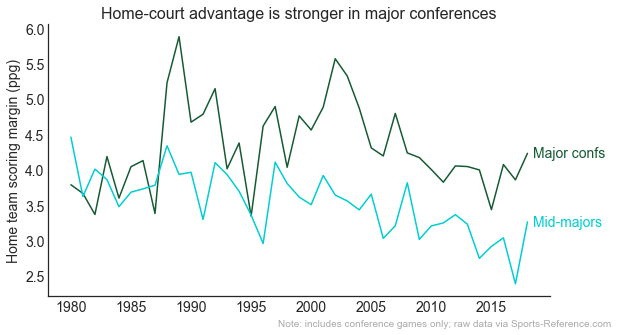

In [23]:
# general parameters:
title = "Home-court advantage is stronger in major conferences"
y_label = "Home team scoring margin (ppg)"
f_name = "NCAA_home_court_advantage_conference"
#colors = ['#145a32', '#27ae60','#00CED1']
colors = ['#145a32','#00CED1']

sns.set_style('white')
draw_graph(graph_df.drop('Other multi-bids', axis=1)[30:], colors, True)
plt.savefig("imgs/"+f_name+".jpg", bbox_inches="tight")
plt.show()
plt.close()

Home-court advantage is stronger in major conferences, but gap has not changed much since ~1990

##### 3A. Do attendance patterns correlate with home-court advantage?

In [24]:
attendance_df = pd.read_csv('attendance_total.csv')

# feed in cleaned games data
games_df = pd.read_csv('conference_games.csv')
games_df['Home_Win'] = np.where( (games_df['Home_Pts'] > games_df['Away_Pts']), 100, 0)
games_df['Home_Margin'] = games_df['Home_Pts'] - games_df['Away_Pts']
#games_df.describe(include='all')

In [25]:
master_sum = games_df.groupby(['Year'])['Home_Win','Home_Margin'].mean()
output_mgn = master_sum[['Home_Margin']].rename(columns={'Home_Margin': 'HCA'})

output_mgn = output_mgn.merge(attendance_df, how='left', left_index=True, right_on='Year').set_index('Year')

# only if using rolling average:
#output_mgn['HCA (5Y avg)'] = output_mgn['HCA'].rolling(5, center=True, min_periods=1).mean()
#output_mgn['Attendance (5Y avg)'] = output_mgn['Avg'].rolling(5, center=True, min_periods=1).mean()
#output_mgn = output_mgn.drop(['HCA','Avg'], axis=1)

#output_mgn.tail()

In [26]:
def draw_graph(df, colors, label_bool): # dataframe of graphs to be drawn; list of colors
    
    fig, ax = plt.subplots(figsize=(9,5))
    plt.tick_params(axis='both', which='major', labelsize=14)
    
    ax2 = ax.twinx()
    #ax.set_xlabel('Year', fontsize=14)
    ax.set_ylabel(y_label, fontsize=14, color=colors[0])
    ax2.set_ylabel(y_label_2, fontsize=14, color=colors[1])
    
    #ax.set_xlim(-0.5,4.5)
    #ax.set_ylim(75,125)
    
    #x_labels = ['< 20', '20-25', '25-30', '30-35', '35 +', '']
    #plt.xticks(range(0, 5), x_labels, fontsize=14)
    
    ax.plot(df[df.columns[0]], '-', color=colors[0])
    ax2.plot(df[df.columns[1]], '-', color=colors[1])
    
    ax2.yaxis.set_label_position("right")
    
    if label_bool==False:
        # custom labels
        ax.text(2018.5, df.loc[2018, df.columns[0]], df.columns[0], ha='left', va='center', fontsize=14, color=colors[0])
        ax.text(2018.5, df.loc[2018, df.columns[1]]+0.1, df.columns[1], ha='left', va='center', fontsize=14, color=colors[1])
        
    ax.set_title(title, fontsize=16)
    
    y_min = ax.get_ylim()[0]
    y_max = ax.get_ylim()[1]
    y_range = (y_max - y_min)
    ax.text(2020, y_min - 0.1*y_range, "Note: Includes conference games only; raw data via Sports-Reference.com and NCAA", ha='right', va='center', fontsize=10, color="#aaaaaa")
    
    sns.despine(ax=ax, right=True, left=False) 
    sns.despine(ax=ax2, left=True, right=False) 
    #return data
    

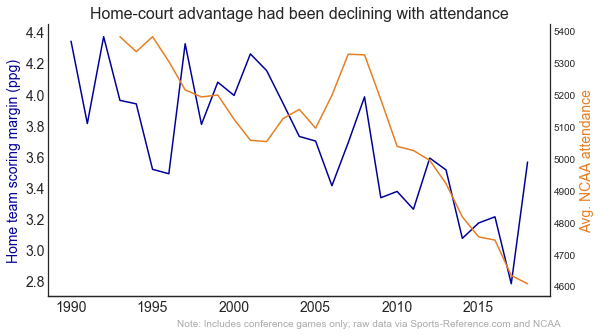

In [27]:
### Graph scoring margin:

# general parameters:
title = "Home-court advantage had been declining with attendance"
y_label = "Home team scoring margin (ppg)"
y_label_2 = "Avg. NCAA attendance"
f_name = "NCAA_home_court_advantage_attendance"
colors = ['#000099','#e67e22']

sns.set_style('white')
draw_graph(output_mgn[40:], colors, True)
#plt.savefig("imgs/"+f_name+".jpg", bbox_inches="tight")
plt.show()
plt.close()

Home-court advantage and attendance are both falling since ~1990, though relationship is not perfect

##### 3B Attendance by conference

In [28]:
# df of conference x change in attendance - created from NCAA pdf release
# http://fs.ncaa.org/Docs/stats/m_basketball_RB/2019/Attendance.pdf

att_df = pd.read_csv('conference_attendance_18.csv')

In [29]:
metric = "Home_Margin" # toggle with Home_Win to analyze different metrics

conf_df = games_df.groupby(['Year','Conference'])[metric].mean().reset_index()\
                .merge(att_df[['Conference','Chg']], how='left', on='Conference')

In [30]:
graph_df = conf_df[conf_df['Year']>=2017]

prior_df = graph_df.copy()
prior_df.rename(columns={'Year':'Prior_Year', 'Home_Margin':'Prior_Margin'}, inplace=True)
graph_df['Prior_Year'] = graph_df['Year']-1

graph_df = graph_df.merge(prior_df[['Conference','Prior_Year','Prior_Margin']], how='left', on=['Conference','Prior_Year'])

graph_df['Chg_Margin'] = graph_df['Home_Margin'] - graph_df['Prior_Margin']

graph_df[graph_df['Year']==2018]

C:\Users\Whitaker Kevin\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,Year,Conference,Home_Margin,Chg,Prior_Year,Prior_Margin,Chg_Margin
32,2018,America East Conference,1.594937,-48.0,2017,1.541667,0.053270
33,2018,American Athletic Conference,4.798319,-175.0,2017,4.565657,0.232663
34,2018,Atlantic 10 Conference,4.050360,122.0,2017,2.412698,1.637661
35,2018,Atlantic Coast Conference,3.704698,-484.0,2017,5.777778,-2.073080
36,2018,Atlantic Sun Conference,4.904762,-114.0,2017,2.303571,2.601190
37,2018,Big 12 Conference,5.676768,-51.0,2017,2.688889,2.987879
38,2018,Big East Conference,3.737374,357.0,2017,3.322222,0.415152
39,2018,Big Sky Conference,3.033613,121.0,2017,2.546296,0.487317
40,2018,Big South Conference,3.575758,-18.0,2017,-0.177778,3.753535
41,2018,Big Ten Conference,3.690647,-38.0,2017,3.849206,-0.158559


In [31]:
def draw_scatter(df, label_bool): # dataframe of graphs to be drawn; list of colors
    
    fig, ax = plt.subplots(figsize=(6,5))
    plt.tick_params(axis='both', which='major', labelsize=14)

    ax.set_xlabel(x_label, fontsize=14)
    ax.set_ylabel(y_label, fontsize=14)
    
    #ax.set_xlim(-0.5,4.5)
    #ax.set_ylim(75,125)
    
    #x_labels = ['< 20', '20-25', '25-30', '30-35', '35 +', '']
    #plt.xticks(range(0, 5), x_labels, fontsize=14)
    
    ax.scatter(df[df.columns[0]], df[df.columns[1]])
    
    ax.set_title(title, fontsize=16)
    
    y_min = ax.get_ylim()[0]
    y_max = ax.get_ylim()[1]
    y_range = (y_max - y_min)
    x_max = ax.get_xlim()[1]
    
    ax.text(x_max, y_min - 0.2*y_range, "Note: Raw data via Sports-Reference.com; includes conference games only", ha='right', va='center', fontsize=10, color="#aaaaaa") 
    #ax.text(2025, y_min - 0.1*y_range, "Note: 5-year rolling average; raw data via Sports-Reference.com; includes conference games only", ha='right', va='center', fontsize=10, color="#aaaaaa")
    #ax.text(2025, y_min - 0.1*y_range, "Note: 5-year rolling average normalized to 2018 avg ppg. Raw data via Sports-Reference.com; analysis by NYC Buckets", ha='right', va='center', fontsize=10, color="#aaaaaa")
    
    sns.despine()
    #return data
    

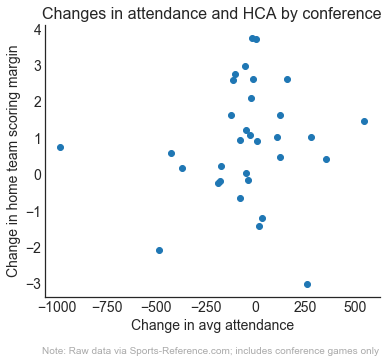

In [32]:
### Graph scoring margin:

# general parameters:
title = "Changes in attendance and HCA by conference"
y_label = "Change in home team scoring margin"
x_label = "Change in avg attendance"
f_name = "NCAA_home_court_advantage_attendance_conference"
#colors = ['#000099','#e67e22']

sns.set_style('white')
draw_scatter(graph_df[['Chg','Chg_Margin']], True)
plt.savefig("imgs/"+f_name+".jpg", bbox_inches="tight")
plt.show()
plt.close()

##### 3C. In-game factors and HCA

In [33]:
trend_df = pd.read_csv('d1_trends.csv')[1:32]\
                .merge(games_df.groupby(['Year'])[metric].mean().reset_index(), how='left', left_on='Season', right_on='Year')\
                .drop('Year', axis=1).rename(columns={'Home_Margin':'HCA'})
trend_df['Season'] = trend_df['Season'].astype(int)
#trend_df

In [34]:
def color_cells(val):
    if val > 0.6:
        color = "#00C957"
    elif val > 0.3:
        color = "#C1FFC1"
    elif val < -0.6:
        color = "red"
    elif val < -0.3:
        color = "#FFB6C1"
    else:
        color = "white"
    return 'background-color: %s' % color

In [35]:
print("Correlation coefficient for each statistic with national home-court advantage annually:")
trend_df.corr()[-1:].drop(['Season','NST%','HCA'], axis=1).round(2).style.applymap(color_cells)

Correlation coefficient for each statistic with national home-court advantage annually:


,Efficiency,Tempo,eFG%,TO%,OR%,FTRate,2P%,3P%,3PA%,FT%,A%,Blk%,Stl%
HCA,-0.51,0.39,0.13,0.82,0.64,0.35,0.07,0.52,-0.7,-0.44,0.75,-0.59,0.73


In [36]:
def color_pcts(val):
    if val > 5:
        color = "#00C957"
    elif val > 2:
        color = "#C1FFC1"
    elif val < -5:
        color = "red"
    elif val < -2:
        color = "#FFB6C1"
    else:
        color = "white"
    return 'background-color: %s' % color

In [37]:
chg_df = trend_df.copy()

chg_df = chg_df.sort_values('Season', ascending=True).set_index('Season')
chg_df = 100*chg_df.pct_change()

In [38]:
print("Percentage change in each statistic nationally in 2017-18 (%):")
chg_df[-1:].drop(['NST%','HCA'], axis=1).round(2).style.applymap(color_pcts)

Percentage change in each statistic nationally in 2017-18 (%):


,Efficiency,Tempo,eFG%,TO%,OR%,FTRate,2P%,3P%,3PA%,FT%,A%,Blk%,Stl%
Season,,,,,,,,,,,,,
2018,0.48,0,0.99,-0.54,-2.05,-5.1,1.42,0.29,3.02,1.42,-0.19,1.09,0
